# <span style="color:#c71ab1ff">An example of Outlier Detection using Quantum Machine Learning</span>

In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

import keras
from keras.models import Sequential
from keras.layers import Dense

import time
import warnings
import matplotlib.colors
warnings.filterwarnings('ignore')

import pygrnd
from pygrnd.qc.qml import QNNClassifier, QNNRegressor, one_epoch, accuracy_loss

jos_palette = ['#4c32ff', '#b332ff', '#61FBF8', '#1E164F', '#c71ab1ff']
sns.set_palette(jos_palette)

## <span style="color:#b332ff">Introduction</span>

### <span style="color:#b332ff">Quantum Machine Learning</span>

In this notebook, we look at how <span style="color:#b332ff">**parametrized quantum circuits**</span> can be used as neural networks to perform a classification task. Using an openly accessible <span style="color:#b332ff">**credit card fraud detection**</span> published on Kaggle and the quantum simulations tools provided by <span style="color:#b332ff">**pennylane**</span>, we look at how quantum machine learning models can perform on a relatively small example compared to their classical counterparts.

Machine learning techniques and especially neural networks have drawn much attention in the past few years and shown interesting results in a variety of domains (e.g. image or speech recognition). Their power lies in their ability to fit a broad range of functions and express interesting relations between variables. Quantum Neural Networks harness the properties of quantum mechanics to span a much larger space which could bring a <span style="color:#b332ff">**potential advantage**</span> compared to the classical models.

However, the development of quantum computers is at an early stage where no relevant advantages over classical computers have been obtained for now. Because of the few number of available qubits and other constraints (such as noise or decoherence), the current quantum machine learning models rely on an <span style="color:#b332ff">**hybrid approach**</span> where the quantum circuit is interfaced with a classical computer. The classical machine takes on tasks that are not currently feasible on a quantum processor. This helps save precious quantum resources.

<img src="images/hybrid.png"   width="470px"  height="282.062px"  style="object-fit:cover"/>



### <span style="color:#b332ff">Binary Classification</span>

The problem considered here can be seen as a <span style="color:#b332ff">**supervised**</span> classification task. Given an input space $X$ of features and an output space $Y$. We seek a function $g: X \rightarrow Y$ that is able to <span style="color:#b332ff">**approximate**</span> the output.

Here there are only two possible outcomes $Y=\{\text{fraud},\text{ non-fraud}\}$ or $Y=\{0,1\}$. This is called a <span style="color:#b332ff">**binary classification**</span> problem. $Y$ can also have more outcomes (multiclass classification) or be continuous (regression).

The model is a quantum circuit with <span style="color:#b332ff">**parameters**</span> $\Theta$. It acts as  function $f_\Theta:x\rightarrow \hat{y}=f_\Theta(x)$. The circuit can be viewed as a unitary $\hat{U}_\theta(x)$ and its output $f_\Theta(x)$ as the expectation value of an Hamiltonian $H$. For an input state $\ket{0^{\otimes n}}$, $f_\Theta(x)=\bra{\psi}H\ket{\psi}$ where $\ket{\psi} = \hat{U}_\theta(x)\ket{0^{\otimes n}}$.

During the learning process, the model is fed with <span style="color:#b332ff">**labeled data**</span> $x_i$ for which the output $y_i$ is known. A chosen loss function $L(y_i, \hat{y_i})$ is minimized through a classical <span style="color:#b332ff">**optimization**</span> process (such as gradient descent) on parameters $\Theta$. The loss function estimates how close the model predictions are from the real data. The performances of the model are then evaluated on unseen data.

## <span style="color:#b332ff">Credit Card Fraud Data</span>

The dataset is taken from Kaggle and can be found [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

It contains two days of european credit card transactions. It is highly <span style="color:#b332ff">**imbalanced**</span> since only 0.172% (492 out of 284 707) of these transactions are frauds. Except for the time and amount of the transaction, the other 28 features are numerical values that come from a PCA transformation. The original features are not provided because of confidentiality issues.

The path to `creditcard.csv` file must be filled in the `filepath` variable so the data can be accessed by the notebook

In [2]:
filepath = ''
df = pd.read_csv(filepath)

### <span style="color:#b332ff">Data Exploration</span>

Because of the few number of qubits available in the current quantum computers or the computational resources needed to simulate large circuits on a quantum feature, we want to <span style="color:#b332ff">**reduce**</span> the number of considered <span style="color:#b332ff">**features**</span> to a smaller number. To do that, we take a first look at the data.

In [3]:
df = df.sample(frac=1)
df_1 = df[df['Class'] == 1] #Fraud transactions
df_0 = df[df['Class'] == 0] #Regular transactions

df_sample = pd.concat([df_1, df_0[:len(df_1)]])

#### <span style="color:#b332ff">Distribution of the features</span>

A first way to select relevant features is to look at how the two classes (1 for frauds and 0 for regular transactions) are distributed. For a given feature, if both <span style="color:#b332ff">**distributions**</span> are similar then it might not be an interesting feature to consider. Conversely, huge disparities between the distributions could help tell apart the two classes.

For computational reasons, we randomly select the same number of regular as fraud transactions (492) to obtain the following distributions. This <span style="color:#b332ff">**undersampling**</span> method will also be used when training the quantum model.

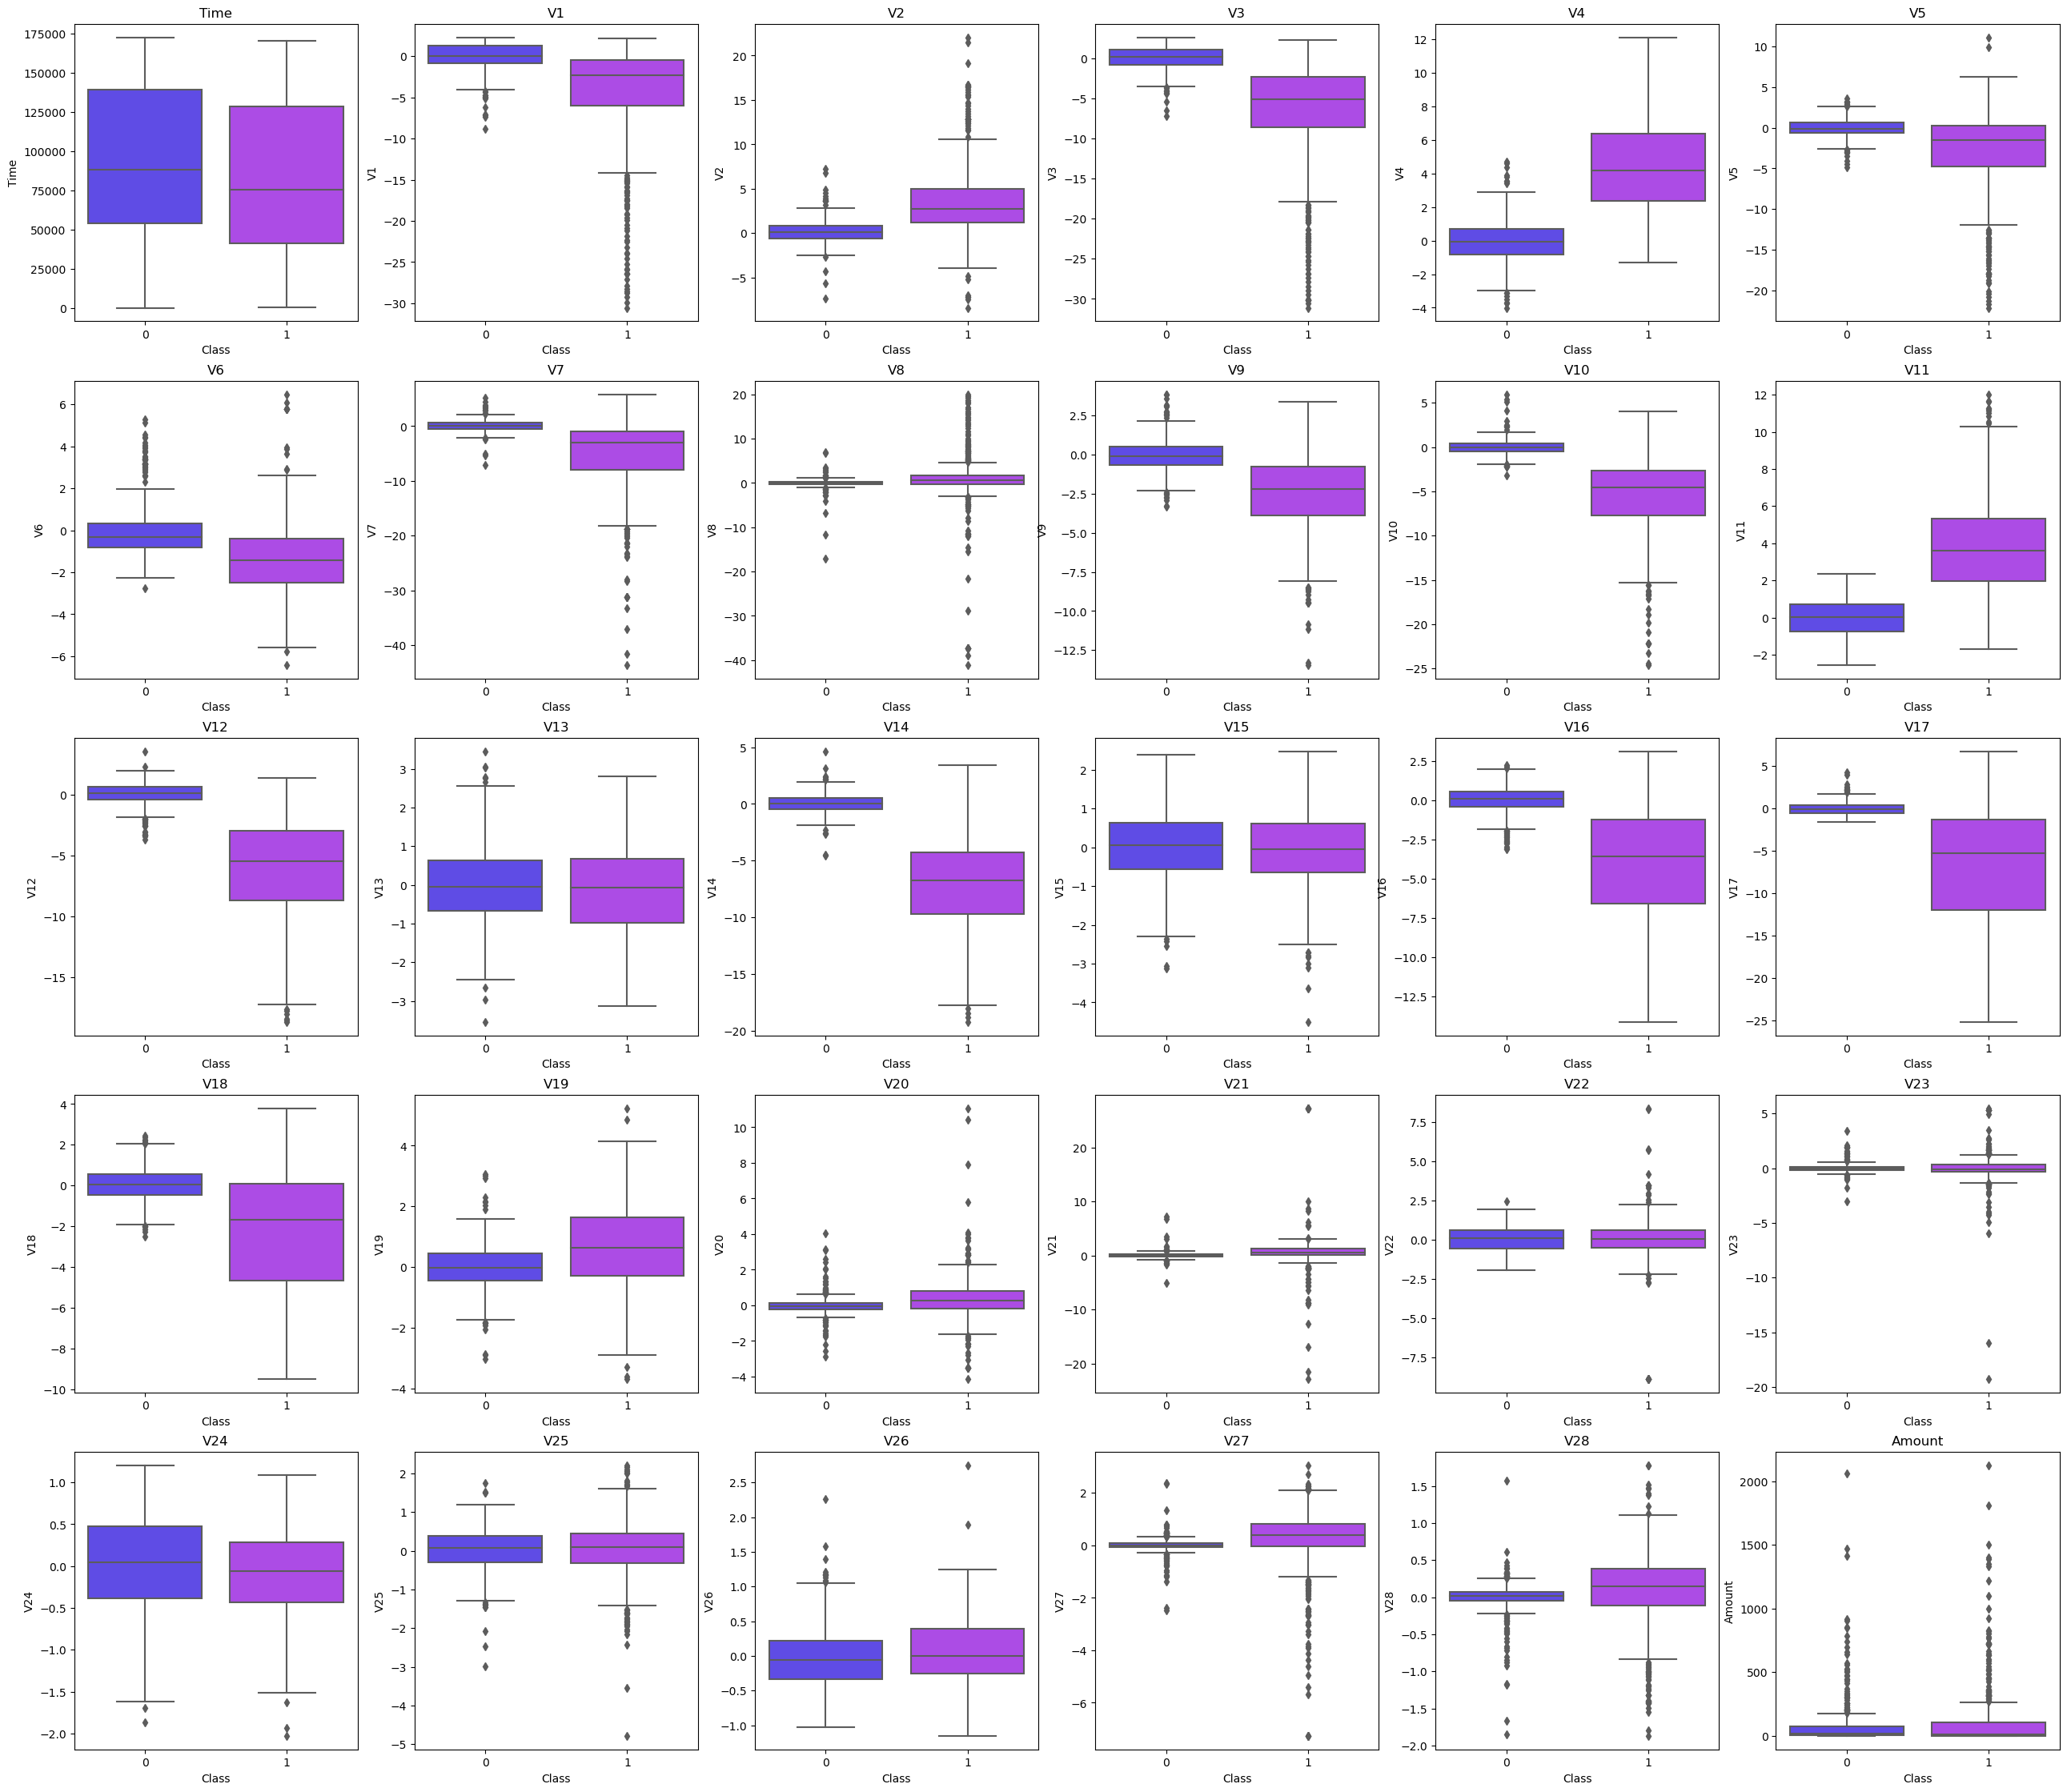

In [4]:
f, axes = plt.subplots(nrows=5, ncols=6, figsize=(32,28))
for k, col in enumerate(df.columns[:-1]):
    i, j = k//6, k%6
    sns.boxplot(y=col, x='Class', data=df_sample, ax=axes[i, j])
    axes[i, j].set_title(col)

#### <span style="color:#b332ff">Correlation between the features</span>

To reduce the number of features, we can also look at the <span style="color:#b332ff">**correlation**</span> matrix. If two features are highly correlated then we can maybe keep only one of the two.

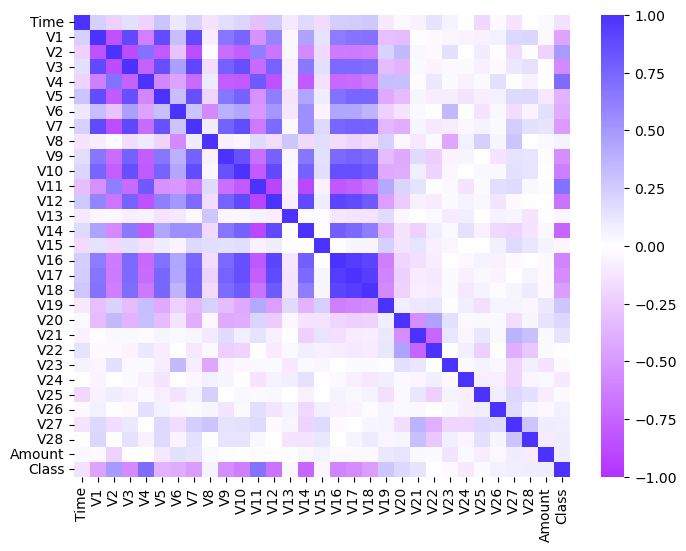

In [5]:
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), jos_palette[1]],[norm(0), "white"],[norm(1.0), jos_palette[0]]]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(8,6))
sns.heatmap(df_sample.corr(method='pearson'), cmap=cmap, vmin=-1, vmax=1)
plt.show()

### <span style="color:#b332ff">Data Preparation</span>

We reduce the number of features to 4 so that the data can be encoded in a PQC that can be simulated. The 4 selected features are `V14`, `V4`, `V12` and `Amount`

The first three features are already <span style="color:#b332ff">**normalized**</span> through the PCA. We also normalize `Amount` in a way that is robust to outliers.

In [6]:
keep_cols = ['V14', 'V4', 'V12', 'Amount', 'Class']
df = df[keep_cols]

rob_scaler = RobustScaler()
df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

X = df.drop('Class', axis=1)
y = df['Class']

The data is separated in a <span style="color:#b332ff">**training**</span> (80%) and <span style="color:#b332ff">**testing**</span> (20%) set.

Because the data is highly <span style="color:#b332ff">**imbalanced**</span>, the training set is undersampled randomly (we randomly select a number of regular credit card transactions so that it matches the number of fraudulent transactions). There could have been other ways to deal with the imbalanced property of the data but this one allows a <span style="color:#b332ff">**training time**</span> of the quantum model that isn't too long. This new training set is `(X_rus, y_rus)`.

The testing set `(X_test, y_test)` is left untouched

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

The classical data will have to be encoded within the <span style="color:#b332ff">**quantum state**</span> of the parametrized quantum circuit. Another normalization $f:x\rightarrow\frac{2}{1+e^{-x}}-1$ is applied so that the values fall in the $[-1,1]$ range. From that value is derived an <span style="color:#b332ff">**angle**</span>  $\theta = \text{arccos}(x)$ in the Bloch sphere that will enable the encoding of the data in the quantum system using <span style="color:#b332ff">**single qubit rotations**</span>.

In [8]:
X_rus_, y_rus = X_rus.to_numpy(), y_rus.to_numpy()
norm = lambda x: 2/(1+np.exp(-x)) - 1
X_rus = norm(X_rus_)

X_test_, y_test = X_test.to_numpy(), y_test.to_numpy()
X_test = norm(X_test_)

## <span style="color:#b332ff">Quantum Neural Network Classifier</span>



### <span style="color:#b332ff">Parametrized Quantum Circuit</span>

<img src="images/pqc.png"   height="202.062px"  style="object-fit:cover"/>

A parametrized quantum circuit (PQC) is essentially defined by three components :

- <span style="color:#b332ff">**Feature Map**</span> : the part of the circuit that encodes the classical data in a superposed quantum state
- <span style="color:#b332ff">**Ansatz**</span> : the variational part of the circuit, which is built of parametrized gates and entangling layers. It transforms the input state so it fits the output data.
- <span style="color:#b332ff">**Measurement**</span> : yields the output through the expectation value of an hamiltonian or the readout of qubits.

Many architectures exist and provide different expressibility or entangling capacities. The chosen architecture here is the following :


#### <span style="color:#b332ff">Feature Map</span>

The <span style="color:#b332ff">**encoding circuit**</span> we choose if a product feature map composed of single qubit rotations. The number of qubits in the circuit is the same as the number of classical values to encode and each value has its own qubit. The feature map can be viewed as a unitary :

\begin{equation*}
U_{\phi(x)} = \bigotimes_{i=1}^n\,R_{\alpha,i}(\phi(x_i))
\end{equation*}

Choosing $\phi(x) = \text{arccos}(x)$, we have :

\begin{equation*}
R_{z}(arccos(x))\ket{0} = cos(arccos(x))\ket{0} - isin(arccos(x))\ket{1} = x\ket{0} - i\sqrt{1-x^2}\ket{1}
\end{equation*}

We can thus obtain the following <span style="color:#b332ff">**superposition**</span> :

\begin{equation*}
    U_{product}(x)\ket{0^{\otimes n}} = \bigotimes_{j=1}^n\,(x_j\ket{0} - i\sqrt{1-x_j^2}\ket{1})
\end{equation*}

#### <span style="color:#b332ff">Ansatz</span>

The ansatz is the <span style="color:#b332ff">**variational**</span> part of the circuit, it can be defined as a unitary $U_\Theta$ where $\Theta = (\theta_i)_{i\in {1...m}} \in \mathbb{C}^m$ is the set of parameters that is <span style="color:#b332ff">**optimized**</span> during the learning process. Each of these parameters is associated to a particular quantum gate in the ansatz circuit.

The so-called <span style="color:#b332ff">**hardware efficient ansatz**</span> used here was originally designed for VQE (Variational Quantum Eigensolver). It is made of successive layers of single qubits rotations along the three axis of the bloch sphere and a ring of entangling CX gates.



#### <span style="color:#b332ff">Measurement</span>

While <span style="color:#b332ff">**expectation values**</span> of complex Hamiltonians can be used for the output of the PQC, we only measure the first qubit in the Z basis here.

### <span style="color:#b332ff">Chosen architecture</span>

The architecture described above is here defined within Pennylane. Because the number of features is 4, we will also used 4 qubits. The plotted circuit has two successive layers of ansatz.

In [9]:
# Feature Map
def rx_encoding(x, wires):
    for i, qb in enumerate(wires):
        qml.RX(np.arccos(x[i%len(x)]), wires=qb)

# Ansatz
def hea_layer(params, wires):
    for qb in wires:
        qml.RX(params[qb, 0], wires=qb)
        qml.RY(params[qb, 1], wires=qb)
        qml.RZ(params[qb, 2], wires=qb)

    qml.broadcast(qml.CNOT, wires=wires, pattern="ring")

(<Figure size 1800x500 with 1 Axes>, <Axes:>)


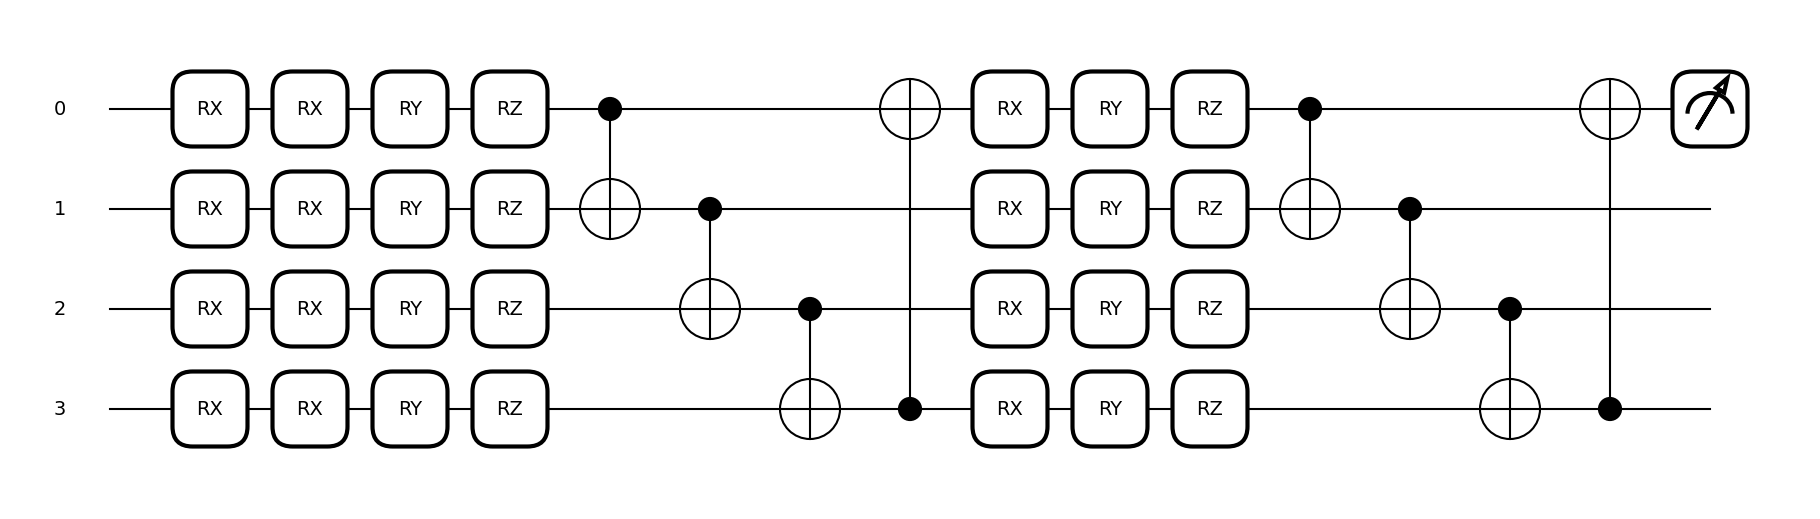

In [10]:
n_qubits = 4
n_layers = 2

dev = qml.device('default.qubit', wires=n_qubits)

# Parametrized Quantum Circuit definition
@qml.qnode(dev)
def pqc(weights, x):
    rx_encoding(x, wires=list(range(n_qubits))) # Feature Map

    for params in weights:
        hea_layer(params, wires=list(range(n_qubits))) # Ansatz

    return qml.expval(qml.PauliZ(0)) # Measurement

model = QNNClassifier(pqc, [n_layers, n_qubits, 3])
model.display_circuit()
plt.show()

These helper functions will help measure the performances of the obtained models

In [11]:
def fancy_confusion_matrix(cm, ax=None):
    labels = ['Regular', 'Fraud']
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_perc.flatten()]
    annot = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    annot = np.asarray(annot).reshape(2,2)

    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False)

def model_metrics(y_true, y_pred):
    print('Precision :', precision_score(y_true, y_pred))
    print('Recall :', recall_score(y_true, y_pred))
    print('F1 Score :', f1_score(y_true, y_pred))
    fancy_confusion_matrix(confusion_matrix(y_true, y_pred))

### <span style="color:#b332ff">Ansatz Layers</span>

Now that the data and model are ready to be used, one first interesting approach is to look at the performances obtained for different numbers of <span style="color:#b332ff">**ansatz layers**</span>. Because the dataset is highly imbalanced, prediction accuracy isn't a relevant metric for the model performances as a model that would always predict 0 would have 99% accuracy. We will rather use other metrics such as <span style="color:#b332ff">**precision**</span>, <span style="color:#b332ff">**recall**</span>, <span style="color:#b332ff">**f1 score**</span>, <span style="color:#b332ff">**ROC AUC**</span> or the full <span style="color:#b332ff">**confusion matrix**</span>.

We test here a number of layers ranging from 1 to 8. We see that the performances of the model seem to stop improving after 4 layers.

In [12]:
losses_dict_layers = {'layers':[], 'optimizer':[], 'epoch':[], 'loss':[]}

layers_list = [1, 2, 3, 4, 5, 6, 7, 8]
precision_layers = []
recall_layers = []
f1_layers = []
train_cfm_layers = []
test_cfm_layers = []

for n_layers in layers_list:
    t = time.time()

    dev = qml.device('default.qubit', wires=n_qubits)

    @qml.qnode(dev)
    def pqc(weights, x):
        rx_encoding(x, wires=list(range(n_qubits)))

        for params in weights:
            hea_layer(params, wires=list(range(n_qubits)))

        return qml.expval(qml.PauliZ(0))

    model = QNNClassifier(qnode=pqc, weights_shape=[n_layers, n_qubits, 3])

    train_losses, _ = model.fit(X_rus, y_rus, epochs=25, batch_size=16, optimizer=qml.AdamOptimizer, learning_rate=0.001, verbose=False)

    for i,loss in enumerate(train_losses):
        losses_dict_layers['layers'].append(n_layers)
        losses_dict_layers['optimizer'].append('Adam')
        losses_dict_layers['epoch'].append(i)
        losses_dict_layers['loss'].append(loss)

    y_hat = model.predict(X_rus)
    train_cfm_layers.append(confusion_matrix(y_rus, y_hat))

    y_hat = model.predict(X_test)
    test_cfm_layers.append(confusion_matrix(y_test, y_hat))
    precision_layers.append(precision_score(y_test, y_hat))
    recall_layers.append(recall_score(y_test, y_hat))
    f1 = f1_score(y_test, y_hat)
    f1_layers.append(f1)

    print(f'{n_layers} layers,    Adam optimizer,     f1-score = {f1},      time = {time.time()-t}')

losses_layers = pd.DataFrame(losses_dict_layers)
losses_layers['loss'] = losses_layers['loss'].astype(float)

Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

1 layers,    Adam optimizer,     f1-score = 0.03320664132826566,      time = 533.4394302368164


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

2 layers,    Adam optimizer,     f1-score = 0.25290697674418605,      time = 897.0897572040558


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

3 layers,    Adam optimizer,     f1-score = 0.19340659340659344,      time = 1252.165470123291


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

4 layers,    Adam optimizer,     f1-score = 0.2194513715710723,      time = 1601.617105960846


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

5 layers,    Adam optimizer,     f1-score = 0.2205513784461153,      time = 1962.5827898979187


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

6 layers,    Adam optimizer,     f1-score = 0.22365038560411307,      time = 2326.0416140556335


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

7 layers,    Adam optimizer,     f1-score = 0.22193877551020408,      time = 2681.825055837631


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

8 layers,    Adam optimizer,     f1-score = 0.21859296482412058,      time = 3059.7274651527405


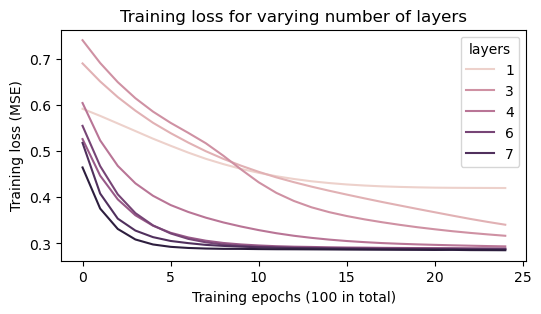

In [28]:
plt.figure(figsize=(6,3))
sns.lineplot(x='epoch', y='loss', hue='layers', data=losses_layers)
plt.title('Training loss for varying number of layers')
plt.ylabel('Training loss (MSE)')
plt.xlabel('Training epochs (100 in total)')
plt.show()

#### <span style="color:#b332ff">Metrics evaluated on the test set for trained models with different numbers of ansatz layers.</span>

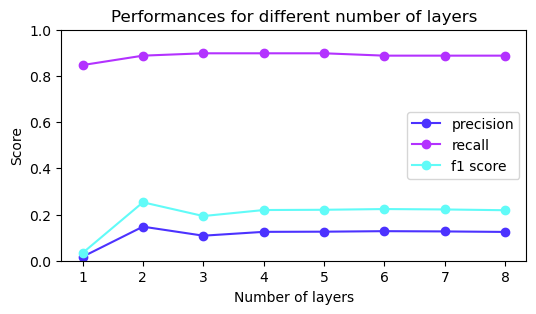

In [29]:
plt.figure(figsize=(6,3))
plt.plot(layers_list, precision_layers, 'o-', label='precision')
plt.plot(layers_list, recall_layers, 'o-', label='recall')
plt.plot(layers_list, f1_layers, 'o-', label='f1 score')
plt.title('Performances for different number of layers')
plt.xlabel('Number of layers')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.legend()
plt.show()

#### <span style="color:#b332ff">Confusion Matrixes obtained with a trained model on the testing set (with different numbers of layers).</span>

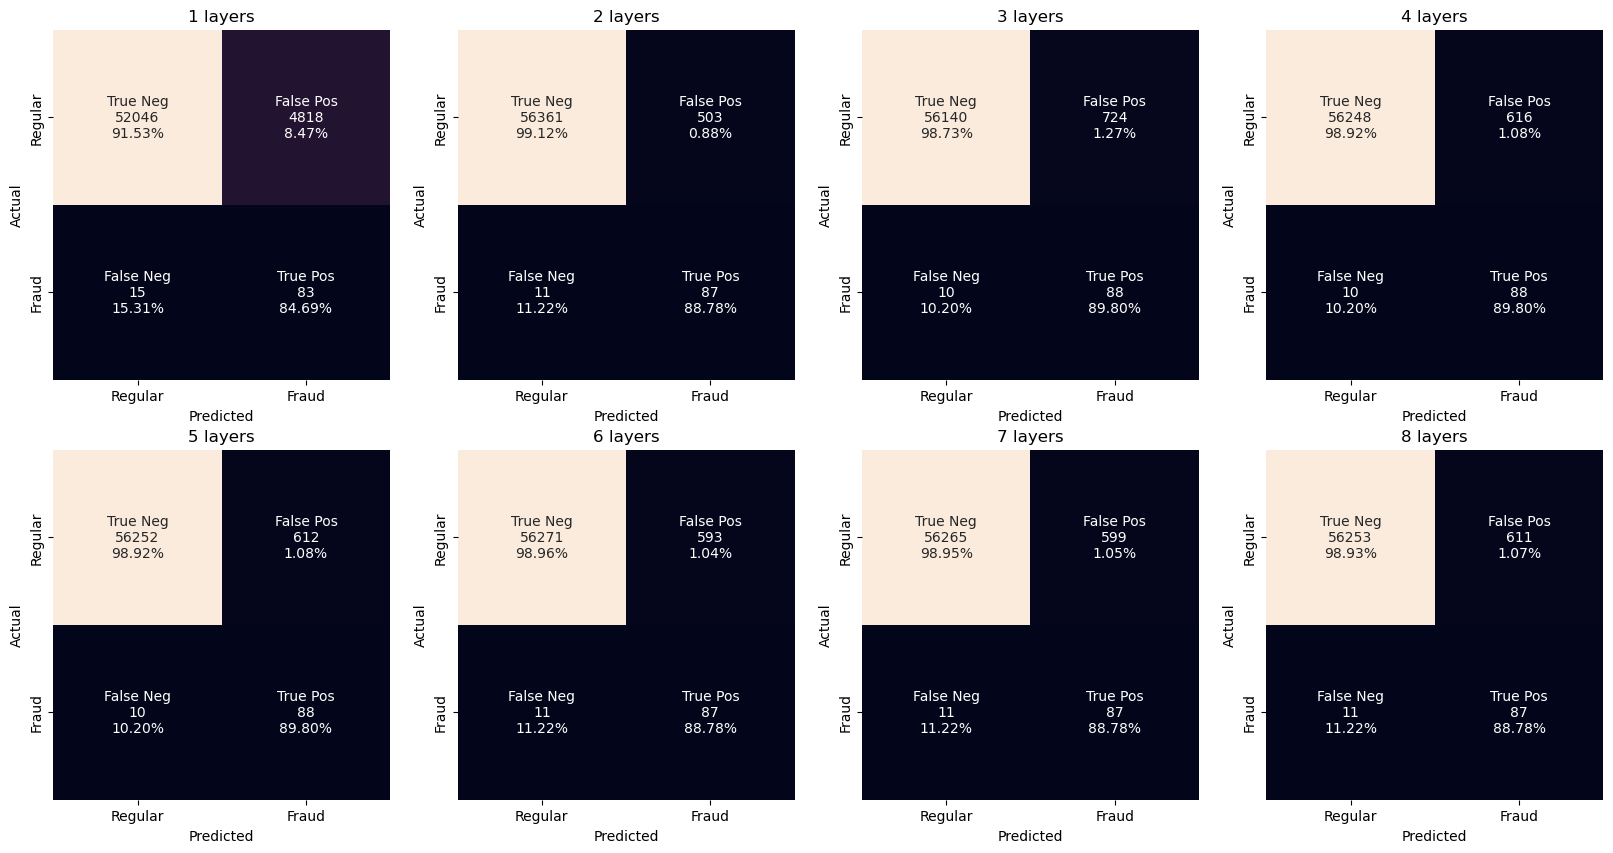

In [30]:
f, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for k,cm in enumerate(test_cfm_layers):
    i,j = k//4, k%4
    fancy_confusion_matrix(cm, ax=ax[i, j])
    ax[i, j].set_title(f'{k+1} layers')
plt.show()

### <span style="color:#b332ff">Quantum Simulation - Number of shots</span>

In the cells above, the simulation of the quantum circuit has been done with the full <span style="color:#b332ff">**statevector**</span>. This means that we know the exact quantum amplitudes and thus the <span style="color:#b332ff">**probability**</span> of measuring a given state. In reality, the final readout of a qubit measurement will either be 0 or 1 and we will have to repeat the computation $n$ times to estimate the probabilities of observing a particular state. This number $n$ is called the number of <span style="color:#b332ff">**shots**</span> and we can simulate it with pennylane.

Here we look at how the model performs when training and evaluating it with a finite number of shots.

In [31]:
losses_dict = {'shots':[], 'optimizer':[], 'epoch':[], 'loss':[]}

opts = ['Adam']

train_cm = {}
test_cm = {}
f1_scores = {}

n_layers = 3

for n_shots in [1, 10, 100, 1000, 10000, -1]:
    for name, optimizer in enumerate([qml.AdamOptimizer]):
        t = time.time()
        
        if n_shots == -1:
            dev = qml.device('default.qubit', wires=n_qubits)
        else:
            dev = qml.device('default.qubit', wires=n_qubits, shots=n_shots)

        @qml.qnode(dev)
        def pqc(weights, x):
            rx_encoding(x, wires=list(range(n_qubits)))

            for params in weights:
                hea_layer(params, wires=list(range(n_qubits)))

            return qml.expval(qml.PauliZ(0))

        model = QNNClassifier(qnode=pqc, weights_shape=[n_layers, n_qubits, 3])

        train_losses, _ = model.fit(X_rus, y_rus, epochs=25, batch_size=16, optimizer=optimizer, learning_rate=0.001, verbose=False)

        for i,loss in enumerate(train_losses):
            losses_dict['shots'].append(n_shots)
            losses_dict['optimizer'].append(opts[name])
            losses_dict['epoch'].append(i)
            losses_dict['loss'].append(loss)

        label = str(n_shots) + '_' + opts[name]

        y_hat = model.predict(X_rus)
        test_cm[label] = confusion_matrix(y_rus, y_hat)

        y_hat = model.predict(X_test)
        test_cm[label] = confusion_matrix(y_test, y_hat)

        f1 = f1_score(y_test, y_hat)
        f1_scores[label] = f1

        print(f'{n_shots} shots,    {opts[name]} optimizer,     {f1} f1-score,      time = {time.time()-t}')

losses_shots = pd.DataFrame(losses_dict)
losses_shots['loss'] = losses_shots['loss'].astype(float)

Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

1 shots,    Adam optimizer,     0.0033079722130334105 f1-score,      time = 6282.783817052841


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

10 shots,    Adam optimizer,     0.0032379924446842958 f1-score,      time = 6463.47586607933


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

100 shots,    Adam optimizer,     0.13996889580093314 f1-score,      time = 6356.760977983475


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

1000 shots,    Adam optimizer,     0.1795918367346939 f1-score,      time = 6597.924908161163


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

10000 shots,    Adam optimizer,     0.18823529411764708 f1-score,      time = 7752.824558973312


Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

-1 shots,    Adam optimizer,     0.19340659340659344 f1-score,      time = 1433.704559803009


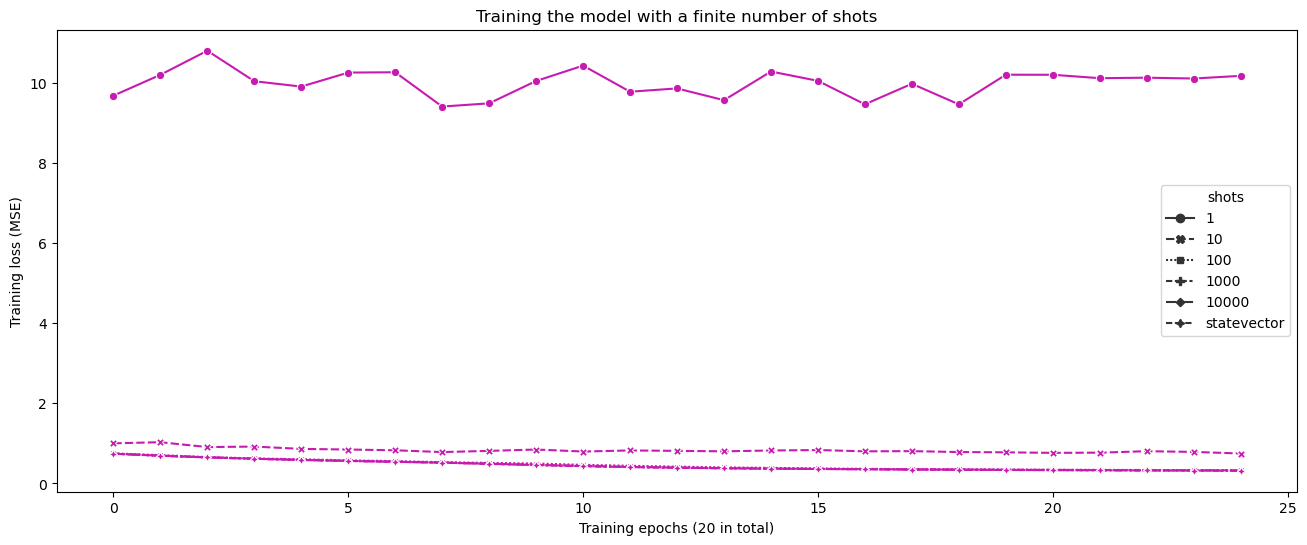

In [34]:
plt.figure(figsize=(16, 6))
losses_shots['shots'] = losses_shots['shots'].astype('str').apply(lambda x:'statevector' if x=='-1' else x)
sns.lineplot(x='epoch', y='loss', style='shots', markers=True, color='#c71ab1ff', data=losses_shots)
plt.ylabel('Training loss (MSE)')
plt.xlabel('Training epochs (20 in total)')
plt.title('Training the model with a finite number of shots')

plt.show()

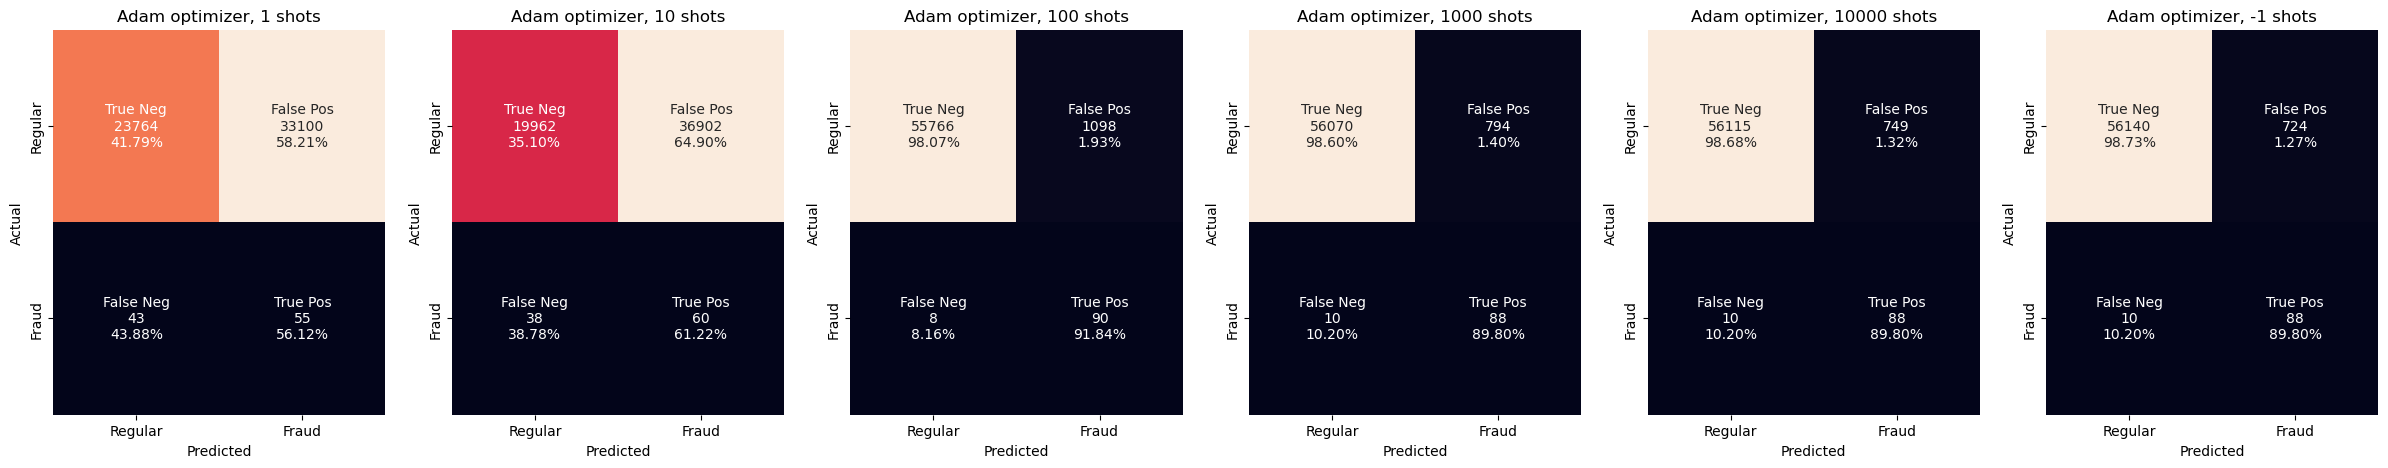

In [35]:
f, ax = plt.subplots(ncols=6, figsize=(30, 5))

shots_dict = {'1':0, '10':1, '100':2, '1000':3, '10000':4, '-1':5}

for key,cm in test_cm.items():
    shots, opt = key.split('_')
    if shots == -1:
        shots = 'statevector'
    i = shots_dict[shots]
    fancy_confusion_matrix(cm, ax=ax[i])
    ax[i].set_title(f'{opt} optimizer, {shots} shots')

plt.show()

### <span style="color:#b332ff">Final QNN test</span>

There are a lot of other <span style="color:#b332ff">**hyperparameters**</span> that we could have tweaked to measure how it impacts the classification results. For example, we also could have :
- Changed the <span style="color:#b332ff">**ansatz architecture**</span> by using other sets of parametrized gates
- Tested different learning rates or batch sizes

However, this notebook is meant as a short introduction to outlier detection using quantum neural networks but the axes detailed above could be used for future analysis.

We will now look more into the performances of a model trained with 4 ansatz layers and an infinite amount of shots to see how it compares to <span style="color:#b332ff">**classical neural networks**</span>.

In [36]:
n_layers = 4

dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def pqc(weights, x):
    rx_encoding(x, wires=list(range(n_qubits)))
    #qml.BasisState(x, wires=list(range(4)))

    for params in weights:
        hea_layer(params, wires=list(range(n_qubits)))

    return qml.expval(qml.PauliZ(0))

In [37]:
model = QNNClassifier(qnode=pqc, weights_shape=[n_layers, n_qubits, 3])

In [38]:
print('Gate depth =', model.get_circuit_specs()['depth'])

Gate depth = 29


In [39]:
train_losses, _ = model.fit(x_train=X_rus, y_train=y_rus, epochs = 25, batch_size=16, optimizer=qml.AdamOptimizer,
                            learning_rate=0.001, verbose=True)

Model Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/25,   train loss = 0.6019611122724713,   train accuracy = 0.5190355329949239


Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/25,   train loss = 0.52143199628678,   train accuracy = 0.8870558375634517


Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/25,   train loss = 0.46648045470856414,   train accuracy = 0.9365482233502538


Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4/25,   train loss = 0.42886715316792084,   train accuracy = 0.9416243654822335


Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5/25,   train loss = 0.4020538454309149,   train accuracy = 0.9403553299492385


Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6/25,   train loss = 0.3821306675795644,   train accuracy = 0.9365482233502538


Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7/25,   train loss = 0.3672746169049569,   train accuracy = 0.9365482233502538


Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8/25,   train loss = 0.35500994017073506,   train accuracy = 0.9352791878172588


Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9/25,   train loss = 0.3447495136056784,   train accuracy = 0.934010152284264


Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10/25,   train loss = 0.33605626118695503,   train accuracy = 0.9352791878172588


Epoch 11:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11/25,   train loss = 0.3284025653736478,   train accuracy = 0.9352791878172588


Epoch 12:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12/25,   train loss = 0.3217783106074412,   train accuracy = 0.9352791878172588


Epoch 13:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13/25,   train loss = 0.31627277943078813,   train accuracy = 0.9352791878172588


Epoch 14:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14/25,   train loss = 0.31179780946196123,   train accuracy = 0.9352791878172588


Epoch 15:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15/25,   train loss = 0.3080432058446415,   train accuracy = 0.9352791878172588


Epoch 16:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16/25,   train loss = 0.30500424897903927,   train accuracy = 0.9378172588832487


Epoch 17:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17/25,   train loss = 0.30258754092454093,   train accuracy = 0.9365482233502538


Epoch 18:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18/25,   train loss = 0.300556551717807,   train accuracy = 0.9378172588832487


Epoch 19:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19/25,   train loss = 0.2990417541990034,   train accuracy = 0.9378172588832487


Epoch 20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20/25,   train loss = 0.2977279480843782,   train accuracy = 0.9378172588832487


Epoch 21:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21/25,   train loss = 0.2966832306553661,   train accuracy = 0.9378172588832487


Epoch 22:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22/25,   train loss = 0.2956878866601939,   train accuracy = 0.9378172588832487


Epoch 23:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23/25,   train loss = 0.2948429036614866,   train accuracy = 0.9378172588832487


Epoch 24:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24/25,   train loss = 0.29402266308851843,   train accuracy = 0.9378172588832487


Epoch 25:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25/25,   train loss = 0.293350895375268,   train accuracy = 0.9378172588832487


#### <span style="color:#b332ff">Performance metrics on train set</span>

Precision : 0.9914529914529915
Recall : 0.883248730964467
F1 Score : 0.9342281879194632


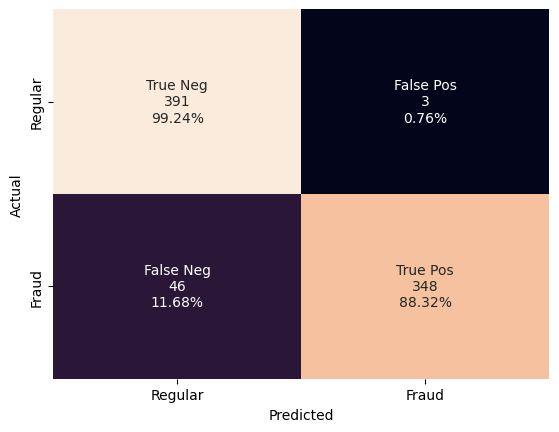

In [40]:
y_hat = model.predict(X_rus)
model_metrics(y_rus, y_hat)

#### <span style="color:#b332ff">Performance metrics on test set</span>

Precision : 0.12535612535612536
Recall : 0.8979591836734694
F1 Score : 0.22000000000000003


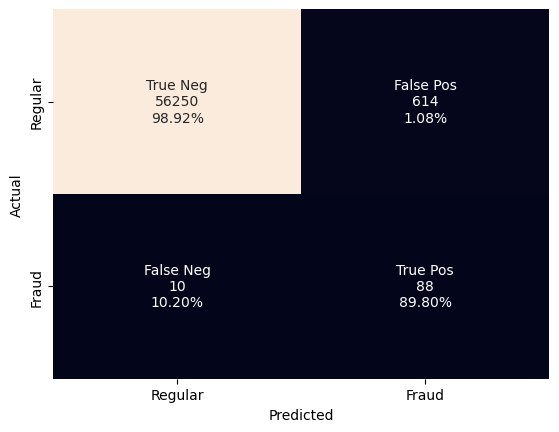

In [41]:
y_hat = model.predict(X_test)
model_metrics(y_test, y_hat)

## <span style="color:#b332ff">Classical Neural Networks</span>

When studying a quantum machine learning model, one systematically has to <span style="color:#b332ff">**compare**</span> its performances to what you can obtain with <span style="color:#b332ff">**classical models**</span>. In particular, the question of whether quantum neural networks perform better than classical neural networks remains open.

Because of the current development stage of quantum computers, it is hard to make a <span style="color:#b332ff">**fair**</span> comparison yet. One thing that can be remarked here is that with a similar number of <span style="color:#b332ff">**trainable parameters**</span>, the quantum neural network seems to perform better than its classical counterpart. However, the classical neural network here is really small when the expressive power of these models is obtained by putting a lot of neurons to work together. Moreover, the training time is nothing alike as a single training epoch of the quantum model takes about 30s when the neural network from keras does it in 30ms.

In [42]:
model = Sequential([
    Dense(6, input_dim=4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 30        
                                                                 
 dense_1 (Dense)             (None, 2)                 14        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________
None


2023-02-07 10:03:54.479661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy())
model.fit(X_rus, y_rus, epochs=1000, batch_size=16, verbose=False)

#### <span style="color:#b332ff">Performance metrics on train set</span>

25/25 [==============================] - 0s 484us/step
Precision : 0.9706666666666667
Recall : 0.9238578680203046
F1 Score : 0.9466840052015605


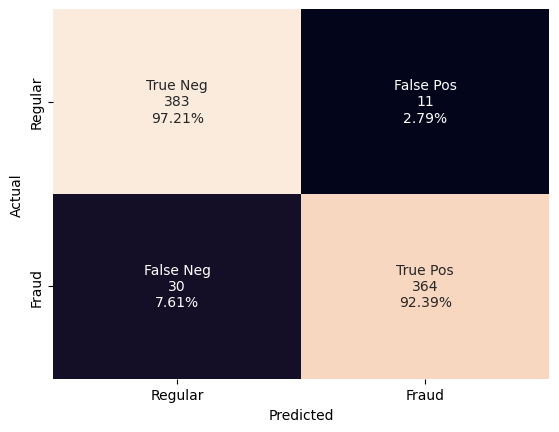

In [44]:
y_hat = model.predict(X_rus).flatten()
y_hat = np.round(y_hat)

model_metrics(y_rus, y_hat)

#### <span style="color:#b332ff">Performance metrics on test set</span>

1781/1781 [==============================] - 1s 313us/step
Precision : 0.03523884103367267
Recall : 0.9183673469387755
F1 Score : 0.06787330316742081


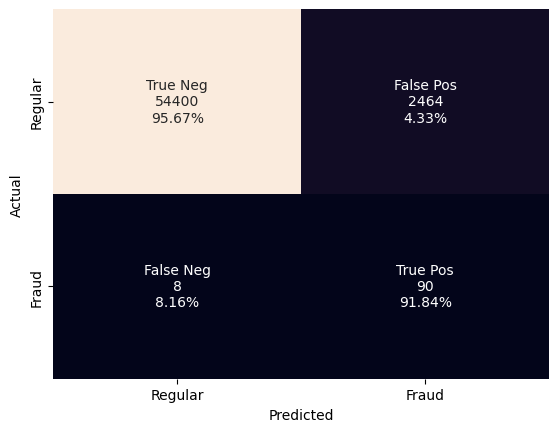

In [45]:
y_hat = model.predict(X_test).flatten()
y_hat = np.round(y_hat)

model_metrics(y_test, y_hat)

## <span style="color:#b332ff">References</span>

- Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

- Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

- Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

- Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

- Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

- Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

- Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

- Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

- Yann-Aël Le Borgne, Gianluca Bontempi Reproducible machine Learning for Credit Card Fraud Detection - Practical Handbook

- Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, Gianluca Bontempi Incremental learning strategies for credit cards fraud detection, IInternational Journal of Data Science and Analytics

- Jacob Biamonte, Peter Wittek, Nicola Pancotti, Patrick Rebentrost, Nathan Wiebe, & Seth Lloyd \(2017\). _Quantum machine learning_. Nature, 549\(7671\), 195–202. https://arxiv.org/pdf/1611.09347.pdf
- Marcello Benedetti, Erika Lloyd, Stefan Sack, & Mattia Fiorentini \(2019\). _Parameterized quantum circuits as machine learning models_. Quantum Science and Technology, 4\(4\), 043001. https://arxiv.org/pdf/1906.07682.pdf
- Chang, D.. \(2022\). _Parameterized Quantum Circuits with Quantum Kernels for Machine Learning: A Hybrid Quantum\-Classical Approach_. https://arxiv.org/ftp/arxiv/papers/2209/2209.14449.pdf 
- Sukin Sim, Peter D. Johnson, & Alán Aspuru\-Guzik \(2019\). _Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum\-Classical Algorithms._ Advanced Quantum Technologies, 2\(12\), 1900070. https://arxiv.org/pdf/1905.10876.pdf
- Hubregtsen, T., Pichlmeier, J., Stecher, P., & Bertels, K.. \(2020\). _Evaluation of Parameterized Quantum Circuits: on the relation between classification accuracy, expressibility and entangling capability_. https://arxiv.org/pdf/2003.09887.pdf
- Patrick Rebentrost, Masoud Mohseni, & Seth Lloyd \(2014\). _Quantum Support Vector Machine for Big Data Classification_. Physical Review Letters, 113\(13\). https://arxiv.org/pdf/1307.0471.pdf
- Vojtěch Havlíček, Antonio D. Cόrcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, & Jay M. Gambetta \(2019\). _Supervised learning with quantum\-enhanced feature spaces_. Nature, 567\(7747\), 209–212. https://arxiv.org/pdf/1804.11326.pdf